In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, f1_score, confusion_matrix,
    classification_report, roc_curve, auc
)
from sklearn.preprocessing import label_binarize, LabelEncoder


# Load all model results
def load_and_clean(true_path, pred_path):
    true = pd.read_csv(true_path).values.ravel()
    pred = pd.read_csv(pred_path).values.ravel()

    # Remove 'unassigned'
    mask = pred != "unassigned"
    return true[mask], pred[mask]

true_scanvi, pred_scanvi = load_and_clean("scANVI_True_Labels_in.csv", "scANVI_Pred_Labels_in.csv")
true_scpred, pred_scpred = load_and_clean("scPred_True_Labels_in.csv", "scPred_Pred_Labels_in.csv")
true_singler, pred_singler = load_and_clean("SingleR_True_Labels_in.csv", "SingleR_Pred_Labels_in.csv")

In [ ]:
# Summary Metrics
results = []
for name, true, pred in [
    ("scANVI", true_scanvi, pred_scanvi),
    ("scPred", true_scpred, pred_scpred),
    ("SingleR", true_singler, pred_singler)
]:
    acc = accuracy_score(true, pred)
    f1 = f1_score(true, pred, average='weighted')
    results.append({"Model": name, "Accuracy": acc, "F1 Score": f1})

df_summary = pd.DataFrame(results)
print(df_summary)

     Model  Accuracy  F1 Score
0   scANVI  0.794457  0.792705
1   scPred  0.825183  0.814754
2  SingleR  0.419621  0.398462


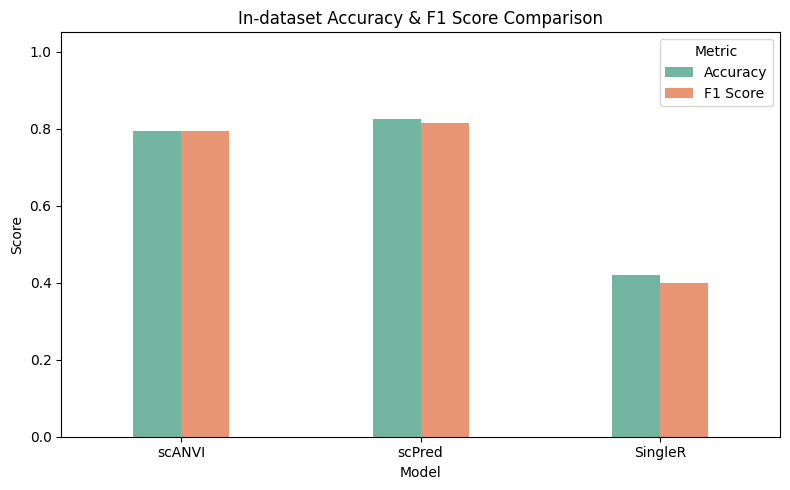

In [15]:
# Barplot of Accuracy and F1 Score

plt.figure(figsize=(8, 5))
df_melt = df_summary.melt(id_vars="Model", value_vars=["Accuracy", "F1 Score"], var_name="Metric")
sns.barplot(data=df_melt, x="Model", y="value", hue="Metric", palette="Set2",width=0.4,)
plt.title("In-dataset Accuracy & F1 Score Comparison")
plt.ylim(0, 1.05)
plt.ylabel("Score")
plt.tight_layout()
plt.savefig("In_Benchmark_Barplot.png", dpi=300)
plt.show()


In [ ]:
# Per-Class F1 Score

def per_class_f1(true, pred, model_name):
    report = classification_report(true, pred, output_dict=True)
    f1_scores = {k: v['f1-score'] for k, v in report.items() if k not in ['accuracy', 'macro avg', 'weighted avg']}
    df = pd.DataFrame.from_dict(f1_scores, orient='index', columns=['F1 Score'])
    df["Model"] = model_name
    return df

f1_scanvi = per_class_f1(true_scanvi, pred_scanvi, "scANVI")
f1_scpred = per_class_f1(true_scpred, pred_scpred, "scPred")
f1_singler = per_class_f1(true_singler, pred_singler, "SingleR")

df_f1_all = pd.concat([f1_scanvi, f1_scpred, f1_singler]).reset_index().rename(columns={"index": "Cell Type"})
print(df_f1_all)


plt.figure(figsize=(10, 6))
sns.barplot(data=df_f1_all, x="F1 Score", y="Cell Type", hue="Model", palette="viridis")
plt.title("Per-Class F1 Score (In-Dataset)")
plt.xlim(0, 1)
plt.tight_layout()
plt.savefig("In_PerClass_F1.png", dpi=300)
plt.show()

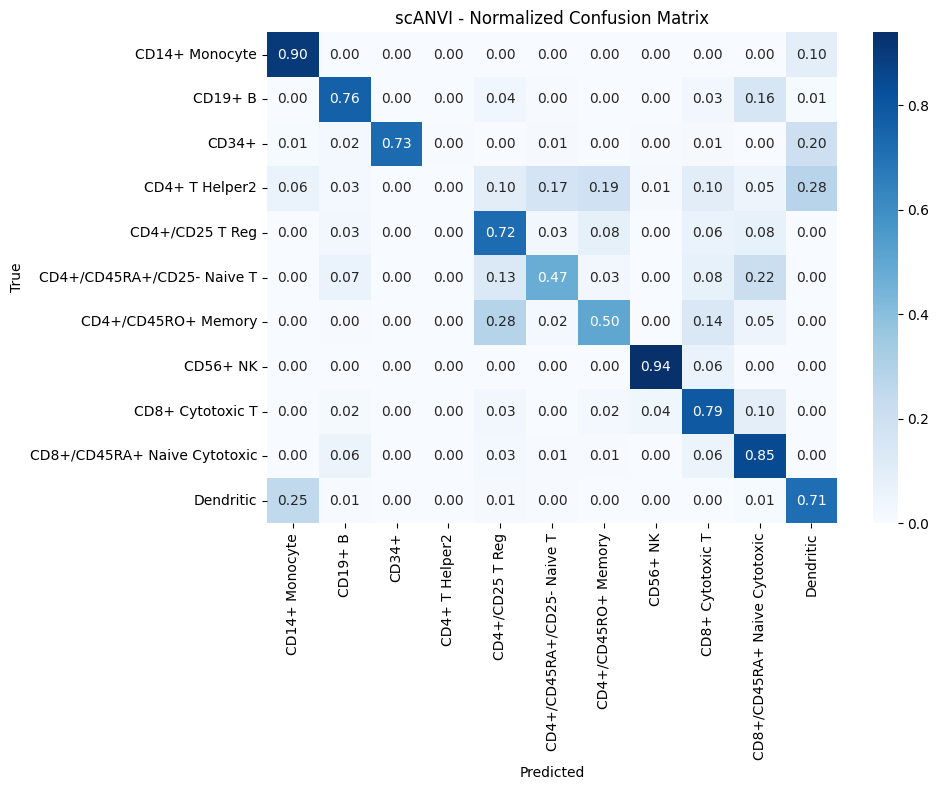

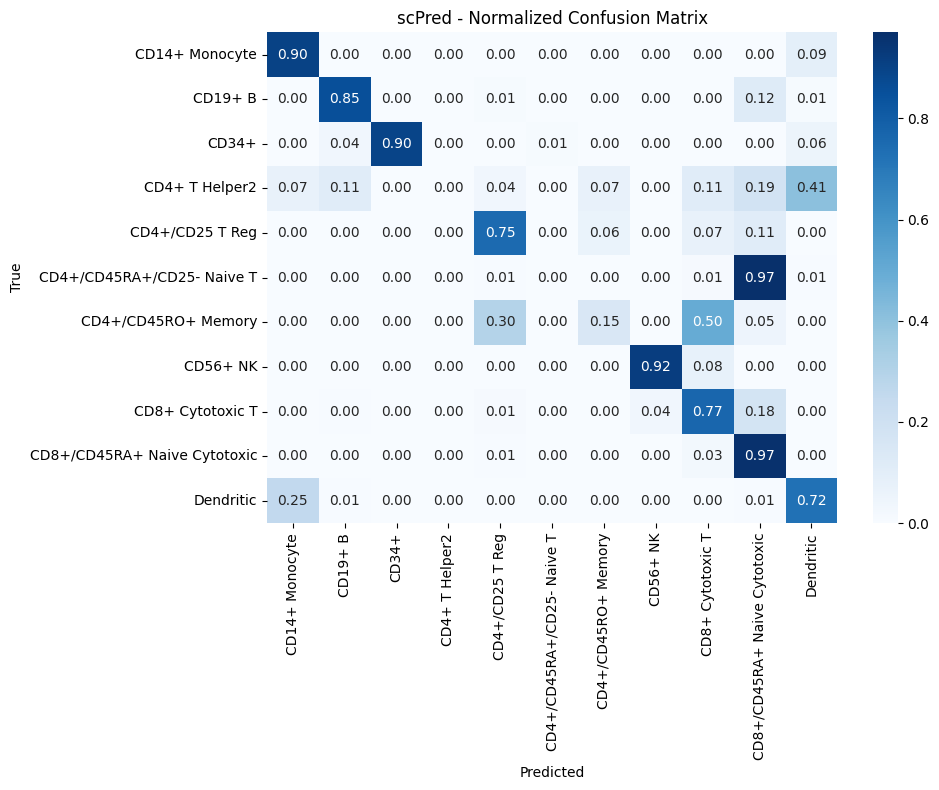

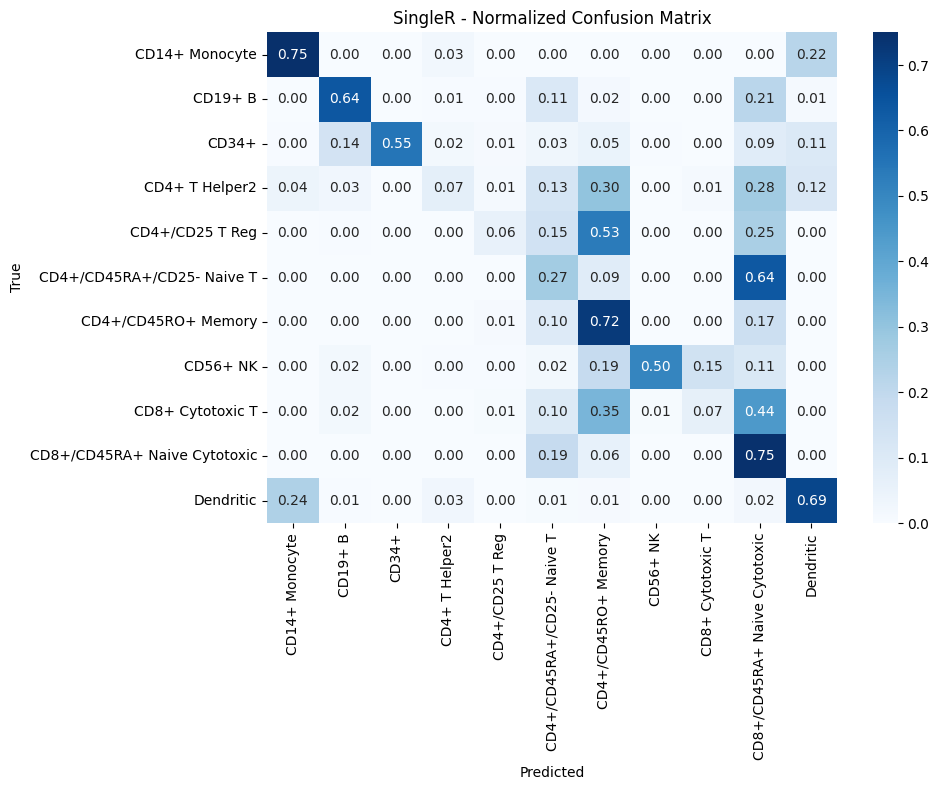

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_confusion(true, pred, title):
    labels = np.unique(np.concatenate([true, pred]))
    cm = confusion_matrix(true, pred, labels=labels, normalize='true')  # Normalized confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues",
                xticklabels=labels, yticklabels=labels)
    plt.title(f"{title} - Normalized Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.savefig(f"{title.replace(' ', '_')}_Confusion_Normalized.png", dpi=300)
    plt.show()

# 使用
plot_confusion(true_scanvi, pred_scanvi, "scANVI")
plot_confusion(true_scpred, pred_scpred, "scPred")
plot_confusion(true_singler, pred_singler, "SingleR")


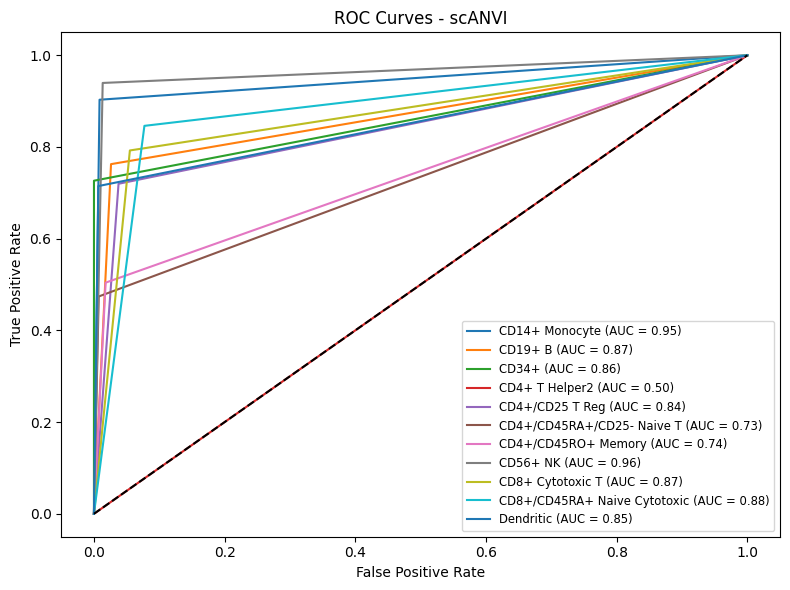

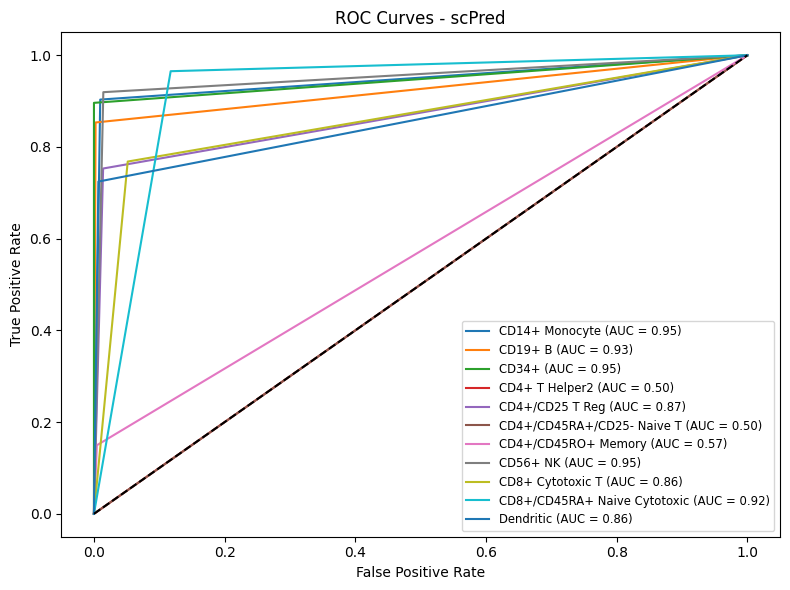

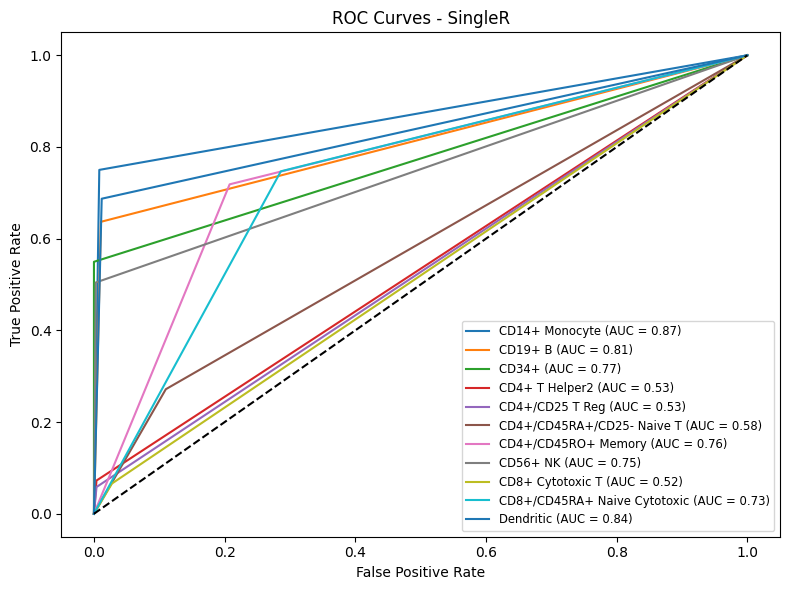

In [17]:
# ROC Curve (Multi-class, One-vs-All)

def plot_roc(true, pred, model_name):
    le = LabelEncoder()
    le.fit(np.concatenate([true, pred]))
    y_true = le.transform(true)
    y_pred = le.transform(pred)

    classes = le.classes_
    y_true_bin = label_binarize(y_true, classes=range(len(classes)))
    y_pred_bin = label_binarize(y_pred, classes=range(len(classes)))

    plt.figure(figsize=(8, 6))
    for i, class_name in enumerate(classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])
        auc_score = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{class_name} (AUC = {auc_score:.2f})")

    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f"ROC Curves - {model_name}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right", fontsize="small")
    plt.tight_layout()
    plt.savefig(f"{model_name}_ROC_Curves.png", dpi=300)
    plt.show()

plot_roc(true_scanvi, pred_scanvi, "scANVI")
plot_roc(true_scpred, pred_scpred, "scPred")
plot_roc(true_singler, pred_singler, "SingleR")
